Found 2527 files belonging to 6 classes.
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Counting images per class...

Image counts per class:
cardboard: 403
glass: 501
metal: 410
paper: 594
plastic: 482
trash: 137


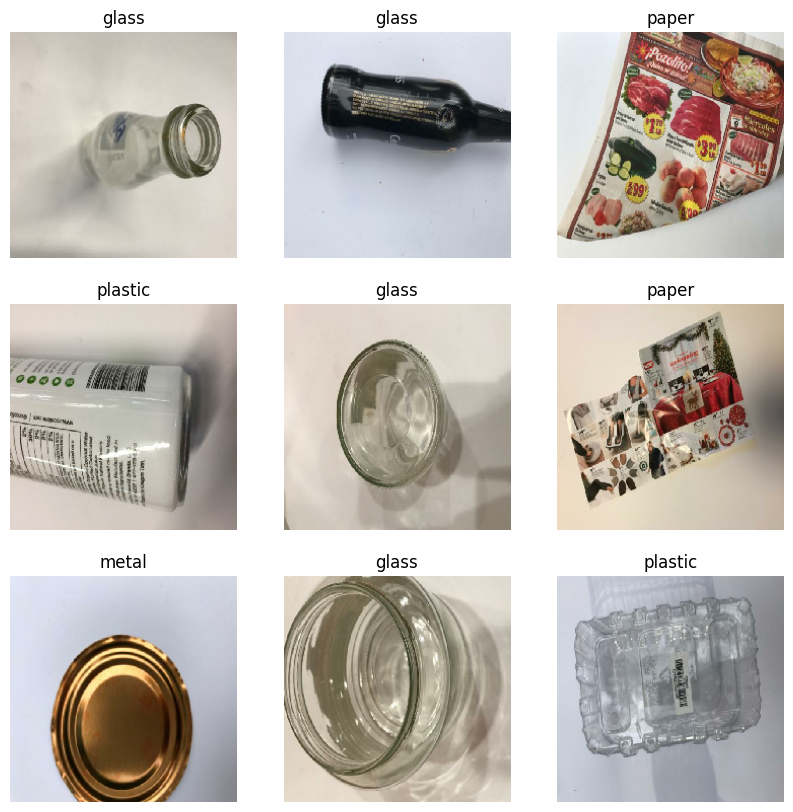

Number of training batches: 33
Number of validation batches: 15
Number of test batches: 31
Class Weights:
{0: np.float64(1.0282651072124755), 1: np.float64(0.8140432098765432), 2: np.float64(1.0404339250493098), 3: np.float64(0.7419127988748242), 4: np.float64(0.9063573883161512), 5: np.float64(2.5857843137254903)}


In [2]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

# Replace 'path/to/your/dataset' with the actual path to your dataset.
dataset_dir = '/content/drive/MyDrive/TrashType_Image_Dataset' # Replace with your dataset path


image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True
)

class_names = train_ds.class_names
print(f"Class names: {class_names}")

image_counts = {name: 0 for name in class_names}


print("Counting images per class...")
for images, labels in train_ds:
    for label in labels.numpy():

        class_index = np.argmax(label)
        class_name = class_names[class_index]
        image_counts[class_name] += 1

print("\nImage counts per class:")
for class_name, count in image_counts.items():
    print(f"{class_name}: {count}")

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the class name from the one-hot encoded label
        class_index = np.argmax(labels[i].numpy())
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

# Define the split ratios
val_split = 0.2
test_split = 0.5 # of the remaining data after validation split

# Calculate the number of validation and test batches
val_batches = tf.data.experimental.cardinality(train_ds).numpy() * val_split
test_batches = tf.data.experimental.cardinality(train_ds).numpy() * (1 - val_split) * test_split
test_batches = int(test_batches)
val_batches = int(val_batches)

# Split the dataset
val_ds = train_ds.take(val_batches)
test_ds = train_ds.skip(val_batches).take(test_batches)
train_ds = train_ds.skip(val_batches).skip(test_batches)

print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Extract labels from the training dataset
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_labels_indices = np.argmax(train_labels, axis=1)

# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels_indices),
    y=train_labels_indices
)

# Convert class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:")
print(class_weight_dict)

In [3]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_model(num_classes):
    inputs = keras.Input(shape=image_size + (3,))

    # Use a pre-trained EfficientNetV2B2 model as the base
    base_model = EfficientNetV2B2(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the base model's layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add a GlobalAveragePooling2D layer
    x = GlobalAveragePooling2D()(base_model.output)

    # Add a dense output layer for classification
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    # Create the model
    model = keras.Model(inputs, outputs)

    return model

# Build the model with the number of classes from the dataset
num_classes = len(class_names)
model = build_model(num_classes)


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Stop after 5 epochs of no improvement
    restore_best_weights=True # Restore the best weights from the epoch with the lowest validation loss
)

# Create a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_trash_type_model.keras', # File path to save the model
    monitor='val_loss',          # Monitor the validation loss
    save_best_only=True,         # Save only the best model
    save_weights_only=False      # Save the entire model (architecture and weights)
)


# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with class weights and callbacks
epochs = 20  # Increase epochs as Early Stopping will prevent overfitting
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight_dict,  # Include class weights
    callbacks=[early_stopping, model_checkpoint] # Include callbacks
)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - accuracy: 0.3714 - loss: 1.6533 - val_accuracy: 0.7354 - val_loss: 0.8805
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.7454 - loss: 0.8320 - val_accuracy: 0.8167 - val_loss: 0.5992
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.8256 - loss: 0.6171 - val_accuracy: 0.8458 - val_loss: 0.5221
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 132s 4s/step - accuracy: 0.8360 - loss: 0.5473 - val_accuracy: 0.8458 - val_loss: 0.4748
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.8700 - loss: 0.4624 - val_accuracy: 0.8562 - val_loss: 0.4546
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.8832 - loss: 0.4084 - val_accuracy: 0.8625 - val_loss: 0.4295
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step - accuracy: 0.8813 - loss: 0.3999 - val_accuracy: 0.8667 - val_loss: 0.4188
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accurac

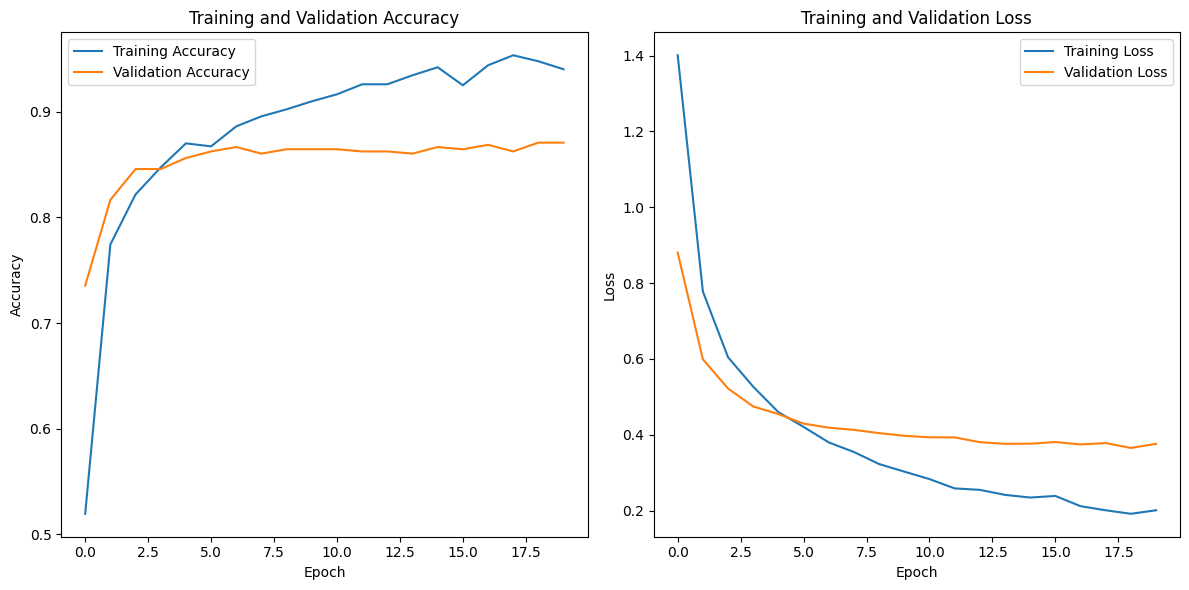

In [4]:
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
#Evaluate model
loss, accuracy = model.evaluate(test_ds)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Get true labels and predicted labels
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))

31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.8609 - loss: 0.3940
Test Loss: 0.33035486936569214
Test Accuracy: 0.8891128897666931
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/ste

In [6]:
# Unfreeze the top layers of the base model
for layer in model.layers[-20:]:  # Unfreeze the last 20 layers, adjust as needed
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Retrain the model for a few epochs
epochs_finetune = 5  # Retrain for 5 epochs, adjust as needed
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs_finetune,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 172s 4s/step - accuracy: 0.9597 - loss: 0.1594 - val_accuracy: 0.8750 - val_loss: 0.3616
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 193s 4s/step - accuracy: 0.9616 - loss: 0.1739 - val_accuracy: 0.8729 - val_loss: 0.3663
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step - accuracy: 0.9546 - loss: 0.1600 - val_accuracy: 0.8729 - val_loss: 0.3641
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.9558 - loss: 0.1477 - val_accuracy: 0.8750 - val_loss: 0.3652
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.9647 - loss: 0.1407 - val_accuracy: 0.8729 - val_loss: 0.3666


In [7]:
import tensorflow as tf
import gradio as gr

def classify_image(image):
    """
    Classifies the input image using the trained model.

    Args:
        image: A NumPy array representing the input image.

    Returns:
        A dictionary containing the class probabilities.
    """
    # Load the best saved model
    model = tf.keras.models.load_model('best_trash_type_model.keras')

    # Resize the image to the expected input size
    img = tf.image.resize(image, image_size)
    # Add a batch dimension
    img = tf.expand_dims(img, axis=0)
    # Make a prediction
    predictions = model.predict(img)
    # Get the class probabilities
    probabilities = predictions[0]
    # Create a dictionary of class names and probabilities
    results = {class_names[i]: float(probabilities[i]) for i in range(len(class_names))}
    return results

# Create the Gradio interface
image_input = gr.Image()
label_output = gr.Label()

interface = gr.Interface(
    fn=classify_image,
    inputs=image_input,
    outputs=label_output,
    title="Trash Type Classifier",
    description="Upload an image of trash to classify its type."
)

In [8]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', # Monitor the validation loss
    factor=0.5,         # Reduce the learning rate by a factor of 0.5
    patience=3,         # Reduce the learning rate after 3 epochs of no improvement
    min_lr=0.0001       # Set a minimum learning rate
)

In [ ]:
# Launch the Gradio interface
interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f39eebe36aa7b582bf.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
